![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de modelos Bagging, Random Forest y XGBoost

En este taller podrán poner en práctica sus conocimientos sobre la construcción e implementación de modelos de Bagging, Random Forest y XGBoost. El taller está constituido por 8 puntos, en los cuales deberan seguir las intrucciones de cada numeral para su desarrollo.

## Datos predicción precio de automóviles

En este taller se usará el conjunto de datos de Car Listings de Kaggle donde cada observación representa el precio de un automóvil teniendo en cuenta distintas variables como año, marca, modelo, entre otras. El objetivo es predecir el precio del automóvil. Para más detalles puede visitar el siguiente enlace: [datos](https://www.kaggle.com/jpayne/852k-used-car-listings).

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Importación de librerías
%matplotlib inline
import pandas as pd

# Lectura de la información de archivo .csv
data = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/dataTrain_carListings.zip')

# Preprocesamiento de datos para el taller
data = data.loc[data['Model'].str.contains('Camry')].drop(['Make', 'State'], axis=1)
data = data.join(pd.get_dummies(data['Model'], prefix='M'))
data = data.drop(['Model'], axis=1)

# Visualización dataset
data.head()

,Price,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE
7,21995,2014,6480,False,False,False,True,False,False,False
11,13995,2014,39972,False,False,False,False,True,False,False
167,17941,2016,18989,False,False,False,False,False,True,False
225,12493,2014,51330,False,False,False,True,False,False,False
270,7994,2007,116065,False,True,False,False,False,False,False


In [3]:
# Separación de variables predictoras (X) y variable de interés (y)
y = data['Price']
X = data.drop(['Price'], axis=1)

In [4]:
# Separación de datos en set de entrenamiento y test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### Punto 1 - Árbol de decisión manual

En la celda 1 creen un árbol de decisión **manualmente**  que considere los set de entrenamiento y test definidos anteriormente y presenten el RMSE y MAE del modelo en el set de test.

In [5]:
print(data)

        Price  Year  Mileage  M_Camry  M_Camry4dr  M_CamryBase  M_CamryL  \
7       21995  2014     6480    False       False        False      True   
11      13995  2014    39972    False       False        False     False   
167     17941  2016    18989    False       False        False     False   
225     12493  2014    51330    False       False        False      True   
270      7994  2007   116065    False        True        False     False   
...       ...   ...      ...      ...         ...          ...       ...   
399845  20825  2017     7542    False       False        False     False   
399928  12995  2014    49685    False       False        False     False   
399934   8812  2009   104692    False       False         True     False   
399951  11595  2010   105077    False        True        False     False   
399976  13995  2012    50453    False        True        False     False   

        M_CamryLE  M_CamrySE  M_CamryXLE  
7           False      False       False  
1

In [6]:
# Celda 1
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Inicializamos
best_feature = None
best_threshold = None
best_mse = np.inf
best_left_value = None
best_right_value = None

# Recorremos todas las variables
for feature in X_train.columns:
    values = X_train[feature].unique()
    for threshold in values:
        left_mask = X_train[feature] <= threshold
        right_mask = ~left_mask

        # Evitar splits sin datos
        if left_mask.sum() == 0 or right_mask.sum() == 0:
            continue

        y_left = y_train[left_mask]
        y_right = y_train[right_mask]

        # Predicción como media en cada grupo
        pred_left = y_left.mean()
        pred_right = y_right.mean()

        # Cálculo del error (MSE)
        mse_left = np.mean((y_left - pred_left) ** 2)
        mse_right = np.mean((y_right - pred_right) ** 2)
        weighted_mse = (len(y_left) * mse_left + len(y_right) * mse_right) / len(y_train)

        # Guardamos si es el mejor split
        if weighted_mse < best_mse:
            best_mse = weighted_mse
            best_feature = feature
            best_threshold = threshold
            best_left_value = pred_left
            best_right_value = pred_right

# Mostrar el mejor split
print(f"Mejor variable: {best_feature}")
print(f"Mejor umbral: {best_threshold}")
print(f"Valor izquierdo (pred): {best_left_value:.2f}")
print(f"Valor derecho (pred): {best_right_value:.2f}")

# Hacemos predicciones en el test
left_mask_test = X_test[best_feature] <= best_threshold
y_pred_test = np.where(left_mask_test, best_left_value, best_right_value)

# Evaluamos
rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
mae = mean_absolute_error(y_test, y_pred_test)

print(f"\nDesempeño en test:")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")

Mejor variable: Year
Mejor umbral: 2012
Valor izquierdo (pred): 9761.05
Valor derecho (pred): 16359.77

Desempeño en test:
RMSE: 2552.27
MAE: 1977.61


RMSE: 11125.47
MAE: 7047.97
RMSE: 2552.27
MAE: 1977.61


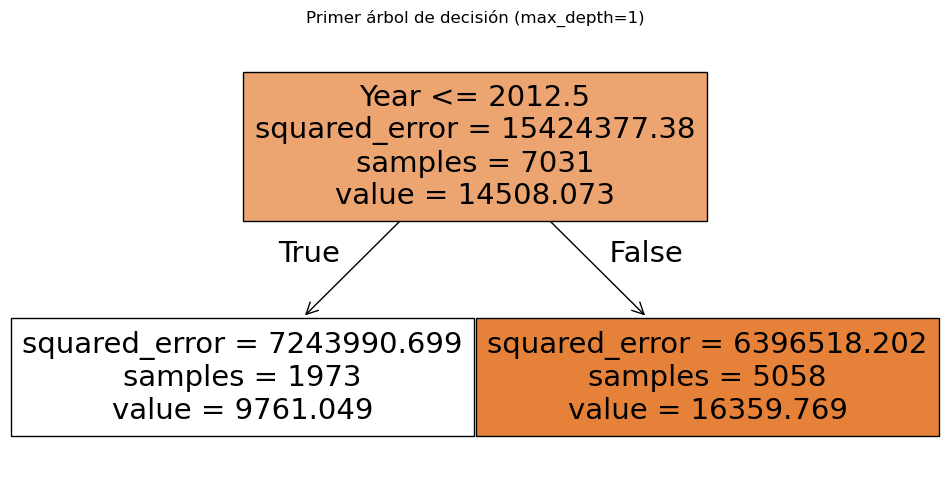

In [13]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# Parámetros
n_estimators = 10
n_samples = X_train.shape[0]

# Inicialización de estructuras
weights = pd.DataFrame(index=X_train.index)
trees = []
alpha = []

# Paso 0: pesos iniciales uniformes
weights[0] = np.ones(n_samples) / n_samples

# Paso 1: primer árbol
tree = DecisionTreeRegressor(max_depth=1)
tree.fit(X_train, y_train, sample_weight=weights[0].values)
trees.append(tree)

# Predicción, error, alpha
y_pred_ = tree.predict(X_train)
residual = y_train - y_pred_
error_t = mean_squared_error(y_train, y_pred_, sample_weight=weights[0].values)
alpha_t = 0.5 * np.log(1 / (error_t + 1e-10))
alpha.append(alpha_t)

# Actualización de pesos
weights[1] = weights[0] * np.exp(alpha_t * (residual ** 2))
if weights[1].sum() == 0 or weights[1].isna().any():
    weights[1] = np.ones(n_samples) / n_samples
else:
    weights[1] /= weights[1].sum()

# Iteraciones siguientes
for t in range(1, n_estimators):
    tree = DecisionTreeRegressor(max_depth=1)
    
    # Asegurar que los pesos sean válidos
    current_weights = weights[t].copy()
    if current_weights.isna().any() or current_weights.sum() == 0:
        current_weights = np.ones(n_samples) / n_samples

    tree.fit(X_train, y_train, sample_weight=current_weights.values)
    trees.append(tree)

    y_pred_ = tree.predict(X_train)
    residual = y_train - y_pred_
    error_t = mean_squared_error(y_train, y_pred_, sample_weight=current_weights.values)
    alpha_t = 0.5 * np.log(1 / (error_t + 1e-10))
    alpha.append(alpha_t)

    weights[t + 1] = current_weights * np.exp(alpha_t * (residual ** 2))
    if weights[t + 1].sum() == 0 or weights[t + 1].isna().any():
        weights[t + 1] = np.ones(n_samples) / n_samples
    else:
        weights[t + 1] /= weights[t + 1].sum()

# --- Predicción final sobre test ---
# Cada árbol predice, ponderamos por alpha
y_preds_test = np.array([model.predict(X_test) for model in trees])
alpha_array = np.array(alpha).reshape(-1, 1)
y_pred_final = np.dot(alpha_array.T, y_preds_test).flatten() / np.sum(alpha)

# --- Métricas ---
rmse = mean_squared_error(y_test, y_pred_final, squared=False)
mae = mean_absolute_error(y_test, y_pred_final)

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")


# --- Visualización del primer árbol ---
plt.figure(figsize=(12, 6))
plot_tree(trees[0], feature_names=X_train.columns, filled=True)
plt.title("Primer árbol de decisión (max_depth=1)")
plt.show()

### Punto 2 - Bagging manual

En la celda 2 creen un modelo bagging **manualmente** con 10 árboles de regresión y comenten sobre el desempeño del modelo.

In [15]:
# Semilla para reproducibilidad
np.random.seed(123)

# Número de árboles
n_estimators = 10

# Número de observaciones de entrenamiento
n_samples = X_train.shape[0]

# Crear muestras bootstrap
samples = [np.random.choice(a=n_samples, size=n_samples, replace=True) for _ in range(n_estimators)]

# DataFrame para guardar predicciones de cada árbol
y_pred = pd.DataFrame(index=X_test.index, columns=range(n_estimators))

# Entrenar un árbol sobre cada muestra bootstrap y predecir sobre el test
for i, sample in enumerate(samples):
    X_train_bootstrap = X_train.iloc[sample]
    y_train_bootstrap = y_train.iloc[sample]

    tree = DecisionTreeRegressor(max_depth=None, random_state=123)
    tree.fit(X_train_bootstrap, y_train_bootstrap)

    y_pred.iloc[:, i] = tree.predict(X_test)

# Desempeño individual de cada árbol
for i in range(n_estimators):
    rmse = np.sqrt(mean_squared_error(y_test, y_pred.iloc[:, i]))
    mae = mean_absolute_error(y_test, y_pred.iloc[:, i])
    print(f'Árbol {i}: RMSE = {rmse:.2f}, MAE = {mae:.2f}')

# Predicción promedio (modelo Bagging)
y_pred_mean = y_pred.mean(axis=1)

# Métricas del modelo Bagging
bagging_rmse = np.sqrt(mean_squared_error(y_test, y_pred_mean))
bagging_mae = mean_absolute_error(y_test, y_pred_mean)

print(f'\nModelo Bagging - RMSE: {bagging_rmse:.2f}, MAE: {bagging_mae:.2f}')

Árbol 0: RMSE = 2141.61, MAE = 1605.30
Árbol 1: RMSE = 2136.35, MAE = 1589.85
Árbol 2: RMSE = 2122.72, MAE = 1577.73
Árbol 3: RMSE = 2087.28, MAE = 1569.61
Árbol 4: RMSE = 2168.52, MAE = 1614.82
Árbol 5: RMSE = 2113.88, MAE = 1576.06
Árbol 6: RMSE = 2127.93, MAE = 1582.15
Árbol 7: RMSE = 2184.41, MAE = 1606.31
Árbol 8: RMSE = 2138.11, MAE = 1586.43
Árbol 9: RMSE = 2132.10, MAE = 1587.77

Modelo Bagging - RMSE: 1796.44, MAE: 1340.02


In [ ]:
# Celda 2


### Punto 3 - Bagging con librería

En la celda 3, con la librería sklearn, entrenen un modelo bagging con 10 árboles de regresión y el parámetro `max_features` igual a `log(n_features)` y comenten sobre el desempeño del modelo.

In [18]:
import numpy as np
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Calcular max_features como logaritmo natural del número de características
n_features = X_train.shape[1]
max_features = int(np.log(n_features))
max_features = max(1, max_features)

# Definir modelo Bagging con 10 árboles y max_features = log(n_features)
bagreg = BaggingRegressor(
    estimator=DecisionTreeRegressor(),
    n_estimators=10,
    max_features=max_features,
    bootstrap=True,
    oob_score=True,
    random_state=1
)

# Entrenar el modelo y predecir
bagreg.fit(X_train, y_train)
y_pred = bagreg.predict(X_test)

# Calcular métricas de desempeño
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print(f'Modelo Bagging (10 árboles, max_features=log(n_features)) - RMSE: {rmse:.2f}, MAE: {mae:.2f}')

Modelo Bagging (10 árboles, max_features=log(n_features)) - RMSE: 2671.01, MAE: 2074.98


In [ ]:
# Celda 3


### Punto 4 - Random forest con librería

En la celda 4, usando la librería sklearn entrenen un modelo de Randon Forest para regresión  y comenten sobre el desempeño del modelo.

In [ ]:
# Celda 4


### Punto 5 - Calibración de parámetros Random forest

En la celda 5, calibren los parámetros max_depth, max_features y n_estimators del modelo de Randon Forest para regresión, comenten sobre el desempeño del modelo y describan cómo cada parámetro afecta el desempeño del modelo.

In [ ]:
# Celda 5


### Punto 6 - XGBoost con librería

En la celda 6 implementen un modelo XGBoost de regresión con la librería sklearn y comenten sobre el desempeño del modelo.

In [ ]:
# Celda 6


### Punto 7 - Calibración de parámetros XGBoost

En la celda 7 calibren los parámetros learning rate, gamma y colsample_bytree del modelo XGBoost para regresión, comenten sobre el desempeño del modelo y describan cómo cada parámetro afecta el desempeño del modelo.

In [ ]:
# Celda 7


### Punto 8 - Comparación y análisis de resultados
En la celda 8 comparen los resultados obtenidos de los diferentes modelos (random forest y XGBoost) y comenten las ventajas del mejor modelo y las desventajas del modelo con el menor desempeño.

In [ ]:
# Celda 8
